In [1]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs
import scipy.io

In [11]:
steps=7000
lr=1e-2
layers=np.array([1,60,60,20,60,60,1])
min=0
max=2*np.pi
total_points=1000
Nu=2
Nf=250

In [12]:
def f_BC(x):
    return torch.sin(x)
def PDE(x):
    return torch.cos(x)

In [37]:
class NN_Module(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.activation=nn.ReLU()
        self.loss_function=nn.MSELoss(reduction='mean')
        self.linears=nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.iter=0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    def forward(self,x):
        if torch.is_tensor(x)!=True:
            x=torch.from_numpy(x)
        a=x.float()
        for i in range(len(layers)-2):
            z=self.linears[i](a)
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    def lossBC(self,x_BC):
        loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
        return loss_BC
    def lossPDE(self,x_PDE):
        g=x_PDE.clone()
        g.requires_grad=True 
        f=self.forward(g)
        f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]),retain_graph=True, create_graph=True)[0]
        loss_PDE=self.loss_function(f_x,PDE(g))
        return loss_PDE
    def loss(self,x_BC,x_PDE):
        loss_bc=self.lossBC(x_BC)
        loss_pde=self.lossPDE(x_PDE)
        return loss_bc+loss_pde
    def closure(self):
        
        optimizer.zero_grad()
        loss = self.lossNN(x_train, y_train)
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(loss)
        return loss   

In [38]:
x = torch.linspace(min,max,total_points).view(-1,1) 
y = f_BC(x)
print(x.shape, y.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])


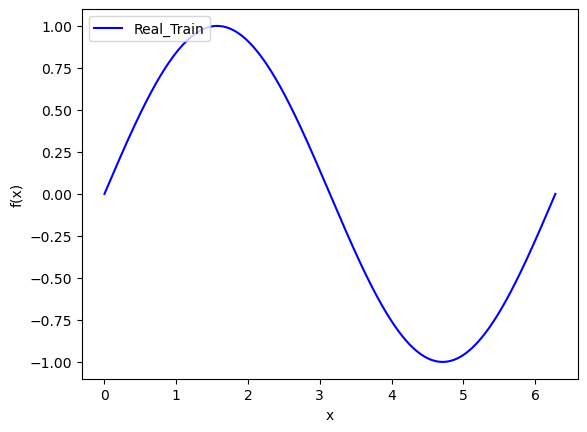

In [39]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [40]:
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions:
BC_1=x[0,:]
BC_2=x[-1,:]

# Total Training points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])

#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]

#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

In [41]:
torch.manual_seed(145)
x_PDE=x_PDE.float()

model = NN_Module(layers)
print(model)

params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

NN_Module(
  (activation): ReLU()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=60, bias=True)
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Linear(in_features=60, out_features=1, bias=True)
  )
)


In [42]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_PDE,x_BC)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
        print(loss)

tensor(1.4788, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(1.0510e-05, grad_fn=<AddBackward0>)
tensor(1.0160e-05, grad_fn=<AddBackward0>)
tensor(8.6525e-06, grad_fn=<AddBackward0>)
tensor(4.4648e-05, grad_fn=<AddBackward0>)
tensor(1.1103e-05, grad_fn=<AddBackward0>)
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(5.8878e-06, grad_fn=<AddBackward0>)
tensor(5.4313e-06, grad_fn=<AddBackward0>)


In [43]:
yh=model(x)
y=f_BC(x)
print(model.lossBC(x))

tensor(1.2353e-05, grad_fn=<MseLossBackward0>)


In [45]:
g=x
g=g.clone()
g.requires_grad=True 
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]),retain_graph=True, create_graph=True)[0]

In [47]:
y_plot=y.detach().numpy()
yh_plot=yh.detach().numpy()
f_x_plot=f_x.detach().numpy()

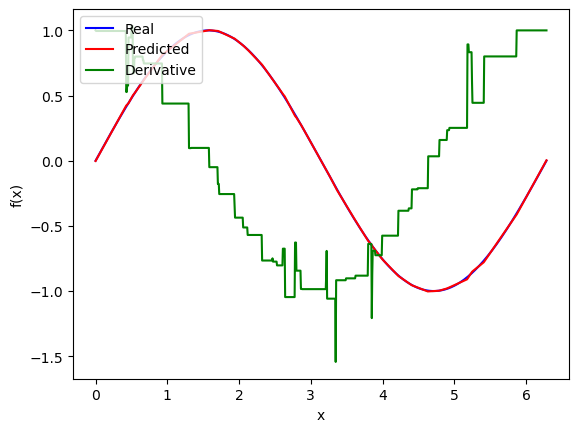

In [48]:
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
ax1.plot(x,f_x_plot,color='green',label='Derivative')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')